- COPY FOR FIXING THE MINMAXSCALING LOOP (12/29/20)

# Using TimeSeriesGenerator for stock data
- 12/23/20
- James M. Irving, Ph.D.

## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

>- Use this notebook as a starting point to turn this into a dashboard 
    - https://colab.research.google.com/drive/1H3L97n1jWL3I3_ZOf_ggZ2EXfRotCV0I?usp=sharing



# OBTAIN

In [1]:

import numpy as np
np.random.seed(321)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,4)

from tensorflow.random import set_seed
set_seed(321)
import tensorflow  as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tf.__version__

'2.4.0'

In [2]:
# !pip install -U pandas-datareader
# %conda install -c anaconda pandas-datareader
import pandas_datareader as pdr

In [3]:
## List of symbols to grab
symbols = ['FB','AAPL','GOOGL','AMZN','MSFT']
data = {}
for stock in symbols:
    data[stock] = pdr.DataReader(stock,'yahoo','2012','2020')['Adj Close']
df = pd.DataFrame(data)
df

,FB,AAPL,GOOGL,AMZN,MSFT
Date,,,,,
2012-01-03,NaN,12.669562,333.038025,179.029999,21.849474
2012-01-04,NaN,12.737655,334.474487,177.509995,22.363672
2012-01-05,NaN,12.879071,329.834839,177.610001,22.592201
2012-01-06,NaN,13.013705,325.335327,182.610001,22.943169
2012-01-09,NaN,12.993064,311.541534,178.559998,22.641172
...,...,...,...,...,...
2019-12-24,205.119995,70.459007,1344.430054,1789.209961,155.730255
2019-12-26,207.789993,71.856941,1362.469971,1868.770020,157.006729
2019-12-27,208.100006,71.829674,1354.640015,1869.800049,157.293686


<AxesSubplot:xlabel='Date'>

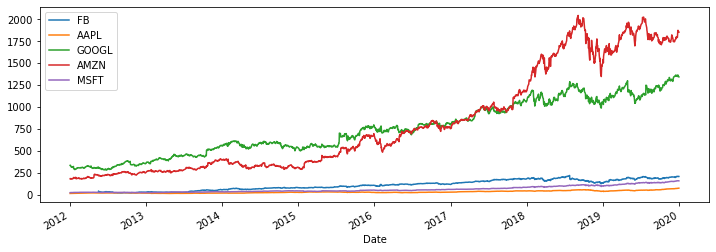

In [4]:
df.plot()

# SCRUB

In [5]:
df.isna().sum()

FB       95
AAPL      0
GOOGL     0
AMZN      0
MSFT      0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()


FB       0
AAPL     0
GOOGL    0
AMZN     0
MSFT     0
dtype: int64

'2.4.0'

### Preparing data [Link](https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data)

In [7]:
## From link above
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


[print(var.shape[0]) for var in [train_df,val_df,test_df]];

1341
384
192


In [8]:
train_df

,FB,AAPL,GOOGL,AMZN,MSFT
Date,,,,,
2012-05-18,38.230000,16.340460,300.500488,213.850006,24.205023
2012-05-21,34.029999,17.292452,307.362366,218.110001,24.601955
2012-05-22,31.000000,17.159668,300.700714,215.330002,24.610222
2012-05-23,32.000000,17.578360,305.035034,217.279999,24.072708
2012-05-24,33.029999,17.416924,302.132141,215.240005,24.039623
...,...,...,...,...,...
2017-09-11,173.509995,38.714279,943.289978,977.960022,71.299881
2017-09-12,172.960007,38.560867,946.650024,982.580017,71.223587
2017-09-13,173.050003,38.270802,950.440002,999.599976,71.729057


In [9]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

## Fit scalers for each column
# for col in train_df.columns:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)
X_val = scaler.transform(val_df)

X_train = pd.DataFrame(X_train,index=train_df.index,
                       columns=train_df.columns)#['BidOpen','BidClose'])
X_val = pd.DataFrame(X_val,index=val_df.index,
                       columns=val_df.columns)
X_test = pd.DataFrame(X_test,index=test_df.index,columns=test_df.columns)#['BidOpen','BidClose'])

X_train
# X_train =pd.DataFrame(index=train_df.index)#train_df.copy()
# X_test = pd.DataFrame(index=test_df.index)
# X_val = pd.DataFrame(index=val_df.index)

# ## Transform all data with fit scalers
# for col,scaler in scalers.items():
#     # scaler = scalers[col]
#     X_train[col] = scaler.transform(train_df[[col]])
#     X_test[col] = scaler.transform(test_df[[col]])
#     X_val[col] = scaler.transform(val_df[[col]])



# # # scaler = MinMaxScaler()
# # X_train = scaler.fit_transform(train_df)#['price'].values.reshape(-1,1))
# # X_val = scaler.transform(val_df)
# # X_test = scaler.transform(test_df)#['price'].values.reshape(-1,1))

# # X_train
# X_train

,FB,AAPL,GOOGL,AMZN,MSFT
Date,,,,,
2012-05-18,0.131596,0.152346,0.028566,0.006666,0.041723
2012-05-21,0.104635,0.187454,0.038038,0.011710,0.049711
2012-05-22,0.085184,0.182557,0.028843,0.008418,0.049877
2012-05-23,0.091604,0.197998,0.034826,0.010727,0.039060
2012-05-24,0.098215,0.192045,0.030819,0.008312,0.038395
...,...,...,...,...,...
2017-09-11,1.000000,0.977457,0.915815,0.911388,0.989444
2017-09-12,0.996469,0.971799,0.920453,0.916858,0.987909
2017-09-13,0.997047,0.961102,0.925684,0.937010,0.998081


<AxesSubplot:xlabel='Date'>

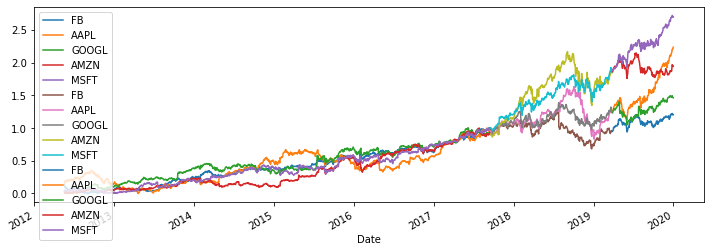

In [10]:


fig,ax= plt.subplots()
X_train.plot(ax=ax)
X_val.plot(ax=ax)
X_test.plot(ax=ax)

In [11]:
X_train.shape

(1341, 5)

In [12]:
## Set the number of features in input sequences
n_features = X_train.shape[1]
n_features

5

In [13]:
# ## Save values as seris
# series = X_train.values
# print(series.shape)

# series = series.reshape((len(series), n_features))
# series.shape

# EXPLORE

# MODEL

## Many to Predict One

In [14]:
column_indices

{'FB': 0, 'AAPL': 1, 'GOOGL': 2, 'AMZN': 3, 'MSFT': 4}

In [15]:
price_col = column_indices['AAPL']

X_train.iloc[:,price_col]

Date
2012-05-18    0.152346
2012-05-21    0.187454
2012-05-22    0.182557
2012-05-23    0.197998
2012-05-24    0.192045
                ...   
2017-09-11    0.977457
2017-09-12    0.971799
2017-09-13    0.961102
2017-09-14    0.948991
2017-09-15    0.963136
Name: AAPL, Length: 1341, dtype: float64

## NOTES: ALSO CHANGES BATCH_SIZE

In [16]:
## Specifying the number of timesteps for the sequences
length=5
price_col = column_indices['AAPL']

## Making the time series generator
train_gen = TimeseriesGenerator(X_train,X_train.iloc[:,price_col],
                                     length,batch_size=1)
train_gen

In [17]:
## Testing out an individual outpuyt from timeseries_gen
ex_X,ex_y =train_gen[0]
ex_X[0], ex_y[0]

(array([[0.13159584, 0.15234641, 0.02856644, 0.00666604, 0.04172312],
        [0.10463474, 0.18745435, 0.03803796, 0.01170996, 0.04971086],
        [0.08518424, 0.18255749, 0.02884281, 0.00841839, 0.04987721],
        [0.09160355, 0.19799817, 0.03482552, 0.01072722, 0.03906046],
        [0.09821543, 0.19204466, 0.03081863, 0.00831183, 0.03839467]]),
 0.18860194365494676)

In [18]:
## MAKE VAL_GEN and TEST_GEN
val_gen = TimeseriesGenerator(X_val,X_val.iloc[:,price_col],length,batch_size=1)
test_gen = TimeseriesGenerator(X_test,X_test.iloc[:,price_col],length,batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2

early_stop = EarlyStopping(monitor='val_mse',patience=4,verbose=1,restore_best_weights=False)

input_shape=(length,n_features)

# Create model architecture
model1 = Sequential()
model1.add(LSTM(units=50,  activation='relu',
                input_shape =input_shape,return_sequences=False,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
# model1.add(LSTM(units=50, activation='relu'))
model1.add(Dense(1))

model1.compile(loss='mse', metrics=['mse'],
              optimizer=optimizers.Adam())

display(model1.summary())
history = model1.fit(train_gen,epochs=25,
callbacks=early_stop, validation_data=val_gen)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/25
1336/1336 [==============================] - 4s 2ms/step - loss: 0.1187 - mse: 0.0179 - val_loss: 0.0081 - val_mse: 0.0048
Epoch 2/25
1336/1336 [==============================] - 2s 2ms/step - loss: 0.0038 - mse: 0.0010 - val_loss: 0.0154 - val_mse: 0.0139
Epoch 3/25
1336/1336 [==============================] - 2s 2ms/step - loss: 0.0024 - mse: 9.6332e-04 - val_loss: 0.0295 - val_mse: 0.0284
Epoch 4/25
1336/1336 [==============================] - 2s 2ms/step - loss: 0.0021 - mse: 9.7886e-04 - val_loss: 0.0247 - val_mse: 0.0238
Epoch 5/25
1336/1336 [==============================] - 2s 2ms/step - loss: 0.0019 - mse: 9.6554e-04 - val_loss: 0.0163 - val_mse: 0.0155
Epoch 00005: early stopping


<Figure size 864x288 with 0 Axes>

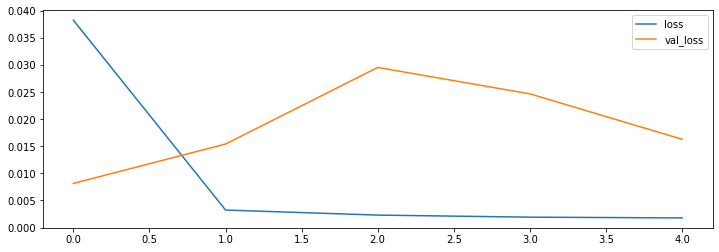

In [20]:
results= pd.DataFrame(history.history)
results

metrics = ['loss']
for metric in metrics:
    plt.figure()
    plot_cols = [col for col in results.columns if metric in col]
    results[plot_cols].plot()

In [21]:
y_hat_test = model1.predict(test_gen)
y_hat_test.shape

(187, 1)

In [22]:
y_hat_test[:6]

array([[1.2156233],
       [1.2219584],
       [1.2290719],
       [1.2326584],
       [1.2368515],
       [1.2384496]], dtype=float32)

In [23]:
test_gen.targets

Date
2019-03-29    1.267640
2019-04-01    1.279307
2019-04-02    1.304449
2019-04-03    1.316477
2019-04-04    1.319552
                ...   
2019-12-24    2.148152
2019-12-26    2.199705
2019-12-27    2.198700
2019-12-30    2.214422
2019-12-31    2.233891
Name: AAPL, Length: 192, dtype: float64

In [24]:
y_test = test_gen.targets[test_gen.length:]
y_test

Date
2019-04-05    1.331400
2019-04-08    1.359436
2019-04-09    1.354010
2019-04-10    1.364139
2019-04-11    1.349036
                ...   
2019-12-24    2.148152
2019-12-26    2.199705
2019-12-27    2.198700
2019-12-30    2.214422
2019-12-31    2.233891
Name: AAPL, Length: 187, dtype: float64

In [25]:
test_index = y_test.index
test_index

DatetimeIndex(['2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
               '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=187, freq=None)

In [26]:

y_hat_test = pd.Series(model1.predict(test_gen).flatten(), index=test_index)
y_hat_test

Date
2019-04-05    1.215623
2019-04-08    1.221958
2019-04-09    1.229072
2019-04-10    1.232658
2019-04-11    1.236851
                ...   
2019-12-24    1.594076
2019-12-26    1.598415
2019-12-27    1.610594
2019-12-30    1.619537
2019-12-31    1.626354
Length: 187, dtype: float32

# iNTERPRET

In [27]:
from sklearn.metrics import r2_score
r2_score(y_test,y_hat_test)

0.01816699244148834

<AxesSubplot:xlabel='Date'>

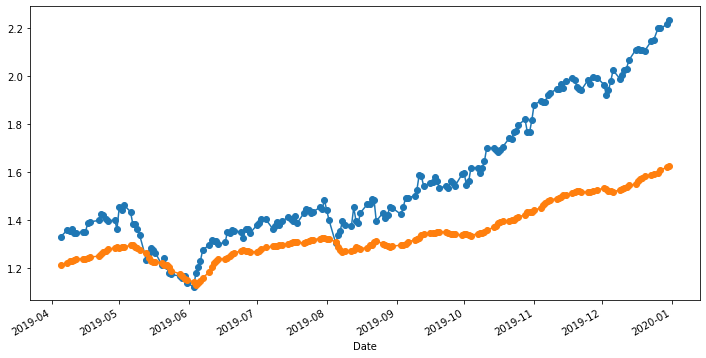

In [28]:
kws = {'marker':'o'}
plt.figure(figsize=(12,6))
y_test.plot(**kws)
y_hat_test.plot(**kws)

## TO DO: INVERSE TRANSFORM WITH A DUMMY MATRIX

## Many to Predict Many

In [29]:
## Specifying the number of timesteps for the sequences
length=5
# price_col = column_indices['AAPL']

## Making the time series generator
train_gen = TimeseriesGenerator(X_train.values,X_train.values,
                                     length,batch_size=64)
## MAKE VAL_GEN and TEST_GEN
val_gen = TimeseriesGenerator(X_val.values,X_val.values,length,batch_size=64)
test_gen = TimeseriesGenerator(X_test.values,X_test.values,length,batch_size=64)
train_gen

In [30]:
ex_X,ex_y =train_gen[1]
ex_X[1], ex_y[1]

(array([[0.00917961, 0.2983422 , 0.07631079, 0.03697695, 0.07057981],
        [0.01097703, 0.31295955, 0.08160958, 0.04129864, 0.06622447],
        [0.01097703, 0.30583925, 0.08134706, 0.03904899, 0.06153397],
        [0.01078444, 0.3065124 , 0.08261132, 0.04442445, 0.06655951],
        [0.00911542, 0.32073008, 0.07611045, 0.04226952, 0.06873724]]),
 array([0.01033509, 0.31972583, 0.08165793, 0.04486253, 0.06773203]))

In [31]:
train_gen.targets

array([[0.13159584, 0.15234641, 0.02856644, 0.00666604, 0.04172312],
       [0.10463474, 0.18745435, 0.03803796, 0.01170996, 0.04971086],
       [0.08518424, 0.18255749, 0.02884281, 0.00841839, 0.04987721],
       ...,
       [0.99704717, 0.96110228, 0.9256841 , 0.93701003, 0.99808101],
       [0.98363084, 0.94899101, 0.91145311, 0.92826017, 0.98963648],
       [0.98799592, 0.96313553, 0.90477238, 0.92184273, 1.        ]])

In [32]:

input_shape=(length,n_features)

# Create model architecture
model2 = Sequential()
model2.add(LSTM(units=50,  activation='relu',
                input_shape =input_shape,return_sequences=True))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
model2.add(LSTM(units=50, activation='relu'))
model2.add(Dense(train_gen.targets.shape[1]))

model2.compile(loss='mse', metrics=['mse'],
              optimizer=optimizers.Adam())

display(model2.summary())
history = model2.fit(train_gen,epochs=50,validation_data=val_gen)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             11200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 31,655
Trainable params: 31,655
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
21/21 [==============================] - 2s 26ms/step - loss: 0.1930 - mse: 0.1930 - val_loss: 0.7668 - val_mse: 0.7668
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.7901 - val_mse: 0.7901
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.1009 - val_mse: 0.1009
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.3728 - val_mse: 0.3728
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.3118 - val_mse: 0.3118
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.2813 - val_mse: 0.2813
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.2649 - val_mse: 0.2649
Epoch 8/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0067 - mse: 0.0

<Figure size 864x288 with 0 Axes>

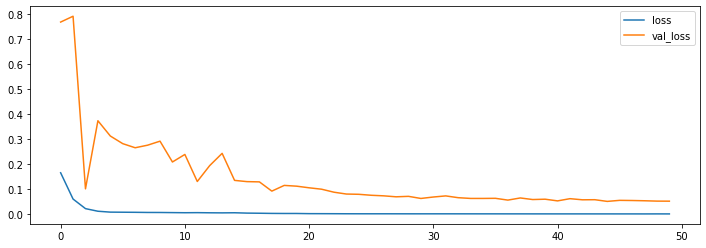

In [33]:
results= pd.DataFrame(history.history)
results

metrics = ['loss']
for metric in metrics:
    plt.figure()
    plot_cols = [col for col in results.columns if metric in col]
    results[plot_cols].plot()

In [34]:
y_test =  pd.DataFrame(test_gen.targets,columns=X_test.columns, index=X_test.index)[length:]
y_hat_test = pd.DataFrame(model2.predict(test_gen),columns=X_test.columns, 
                          index=X_test.index[test_gen.length:])
y_hat_test

,FB,AAPL,GOOGL,AMZN,MSFT
Date,,,,,
2019-04-05,1.577607,1.394845,1.559941,1.788959,1.630169
2019-04-08,1.594456,1.411076,1.577897,1.810677,1.647558
2019-04-09,1.604389,1.429872,1.586699,1.818987,1.657600
2019-04-10,1.609714,1.441397,1.591460,1.823255,1.662737
2019-04-11,1.613069,1.451915,1.594167,1.825121,1.666046
...,...,...,...,...,...
2019-12-24,2.130009,2.861269,1.878741,1.801280,2.177188
2019-12-26,2.140812,2.885524,1.885726,1.805872,2.187903
2019-12-27,2.155442,2.924442,1.896629,1.819759,2.204066


In [35]:
for col in y_hat_test.columns:
    y_true = y_test[col]
    y_pred = y_hat_test[col]
    r2 = r2_score(y_true,y_pred)
    print(f"Column {col} R^2= {r2}")

Column FB R^2= -154.23216765067002
Column AAPL R^2= -0.7704477864138435
Column GOOGL R^2= -14.002483776607962
Column AMZN R^2= -0.3267594220063714
Column MSFT R^2= -3.4294249120433937


In [36]:
# fig,ax= plt.subplots()
# y_test.plot(ax=ax)
# y_hat_test.plot(ax=ax,ls=':')

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# TO DO/FUTURE WORK

- 